<a href="https://colab.research.google.com/github/souaddev/Master-Thesis-Anomaly-Detection-in-Industrial-Control-Systems-Using-Dynamic-Time-Warping/blob/main/SWaT_Data_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Thesis: Dynamic Time Warping Based Anomaly Detection For Industrial Control System**
**Souad Asroubi**

#**1. Import libraries**

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense,Input,Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score,accuracy_score,classification_report
from sklearn.preprocessing import OneHotEncoder
from scipy.spatial.distance import euclidean
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer,r2_score
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from keras.layers import TimeDistributed,Reshape



In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# **2. Dataset Loading**

In [ ]:
dataset_path_normal = '/content/drive/My Drive/swat/SWaT_Dataset_Normal_v0.csv'
dataset_path_attack = '/content/drive/My Drive/swat/SWaT_Dataset_Attack_v0.csv'

In [ ]:
SWaT_normal = pd.read_csv(dataset_path_normal)
SWaT_attack = pd.read_csv(dataset_path_attack)

data = pd.concat([SWaT_normal, SWaT_attack])

In [ ]:
print(data.shape)
data.head()

(946719, 53)


,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
0,22/12/2015 4:00:00 PM,2.470294,261.5804,2,2,1,244.3284,8.19008,306.101,2.471278,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal
1,22/12/2015 4:00:01 PM,2.457163,261.1879,2,2,1,244.3284,8.19008,306.101,2.468587,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal
2,22/12/2015 4:00:02 PM,2.439548,260.9131,2,2,1,244.3284,8.19008,306.101,2.467305,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal
3,22/12/2015 4:00:03 PM,2.428338,260.2850,2,2,1,244.3284,8.19008,306.101,2.466536,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal
4,22/12/2015 4:00:04 PM,2.424815,259.8925,2,2,1,244.4245,8.19008,306.101,2.466536,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 946719 entries, 0 to 449918
Data columns (total 53 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Timestamp      946719 non-null  object 
 1   FIT101         946719 non-null  float64
 2   LIT101         946719 non-null  float64
 3   MV101          946719 non-null  int64  
 4   P101           946719 non-null  int64  
 5   P102           946719 non-null  int64  
 6   AIT201         946719 non-null  float64
 7   AIT202         946719 non-null  float64
 8   AIT203         946719 non-null  float64
 9   FIT201         946719 non-null  float64
 10  MV201          946719 non-null  int64  
 11  P201           946719 non-null  int64  
 12  P202           946719 non-null  int64  
 13  P203           946719 non-null  int64  
 14  P204           946719 non-null  int64  
 15  P205           946719 non-null  int64  
 16  P206           946719 non-null  int64  
 17  DPIT301        946719 non-nul

#**3. Visualization**

In [ ]:
data['Normal/Attack'].unique()

array(['Normal', 'Attack', 'A ttack'], dtype=object)

In [ ]:
# Remove extra spaces
data['Normal/Attack'] = data['Normal/Attack'].str.replace(' ', '')

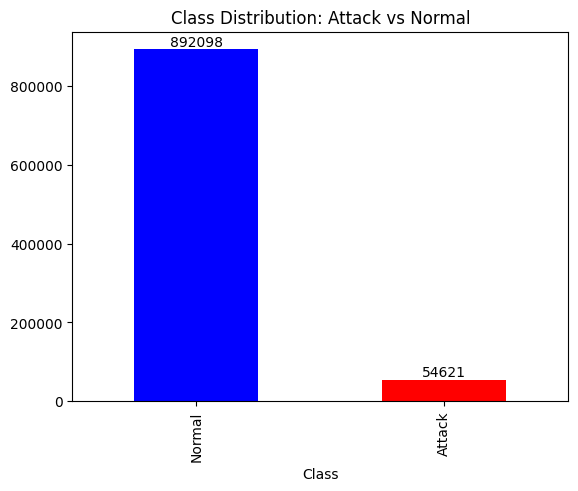

In [ ]:
# Class distribution (Normal vs. Attack) in SWaT
class_distribution = data['Normal/Attack'].value_counts()
fig, ax = plt.subplots()
bar_plot = class_distribution.plot(kind='bar', color=['blue', 'red'], ax=ax)

plt.title('Class Distribution: Attack vs Normal')
plt.xlabel('Class')
for i, count in enumerate(class_distribution):
    ax.text(i, count, str(count), ha='center', va='bottom')

plt.show()

In [ ]:
# Converting the Timestamp to a datetime and set it as an index
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data= data.set_index('Timestamp')

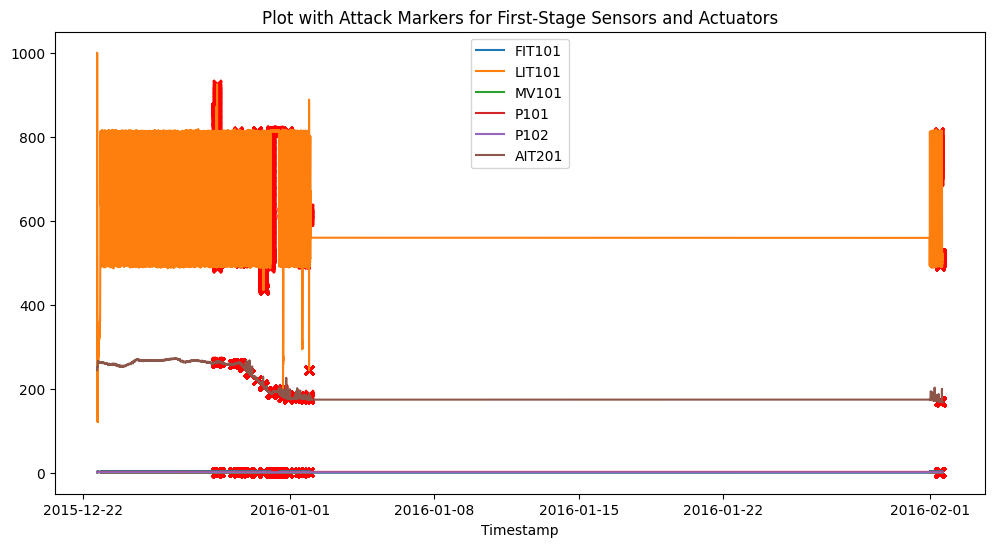

In [ ]:
attack_data = data[data['Normal/Attack'] == 'Attack']

# List of all sensors and actuators in the first stage
first_stage_features = ['FIT101', 'LIT101', 'MV101', 'P101', 'P102', 'AIT201']

plt.figure(figsize=(12, 6))
for feature in first_stage_features:
    plt.plot(data.index, data[feature], label=feature)
    plt.scatter(attack_data.index, attack_data[feature], color='red', marker='x', label=None)
plt.legend()
plt.xlabel('Timestamp')
plt.title('Plot with Attack Markers for First-Stage Sensors and Actuators')
plt.show()

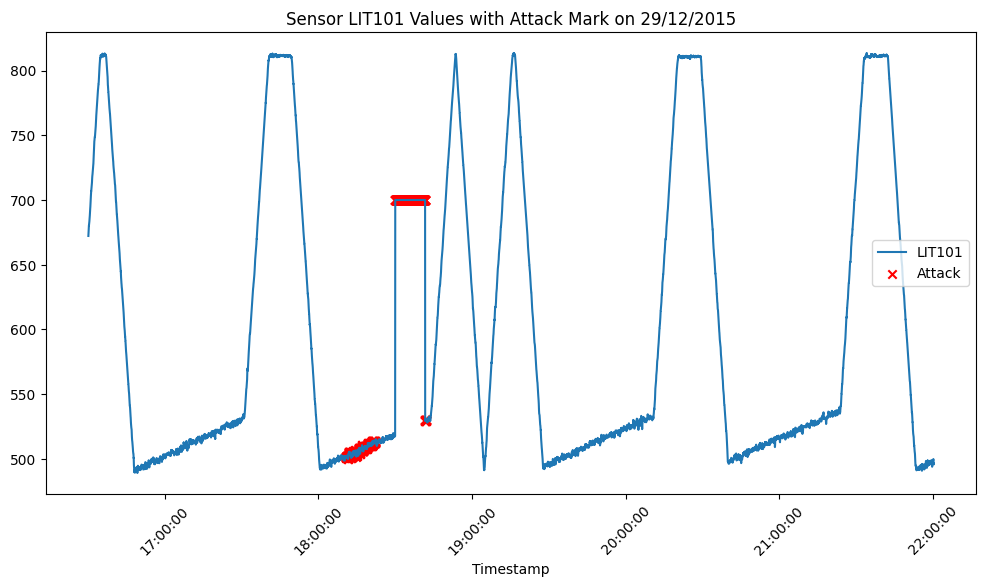

In [ ]:
data.index = pd.to_datetime(data.index)

# Filter data for the specific time range on 29/12/2015
start_time = '2015-12-29 16:30:11'
end_time = '2015-12-29 22:00:19'
specific_time_range = data[start_time:end_time]

# Filter for attack data within the specified time range
attack_data2 = specific_time_range[specific_time_range['Normal/Attack'] == 'Attack']

# Plot 'FIT101' for the specific time range
plt.figure(figsize=(12, 6))
plt.plot(specific_time_range.index, specific_time_range['LIT101'], label='LIT101')
plt.scatter(attack_data2.index, attack_data2['LIT101'], color='red', marker='x', label='Attack')
plt.xlabel('Timestamp')
plt.title('Sensor LIT101 Values with Attack Mark on 29/12/2015')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M:%S'))
plt.legend()
plt.show()


<ipython-input-67-c4c7fa7e50bd>:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  specific_day = data[data.index.date == pd.to_datetime('31/12/2015').date()]


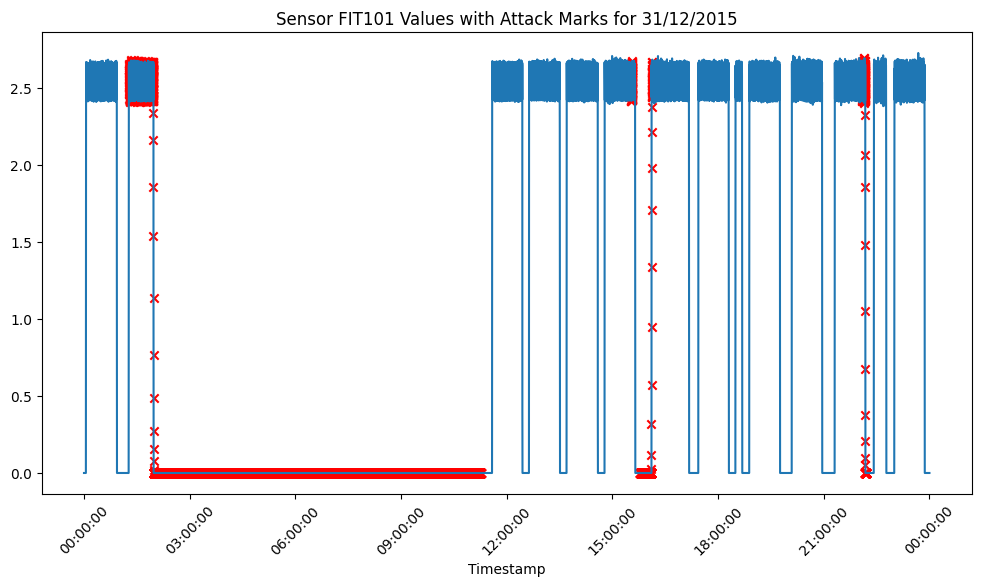

In [ ]:
specific_day = data[data.index.date == pd.to_datetime('31/12/2015').date()]
attack_data2 = specific_day[specific_day['Normal/Attack'] == 'Attack']
# Plot 'FIT101' for the specific day
plt.figure(figsize=(12, 6))
plt.plot(specific_day.index, specific_day['FIT101'])
plt.scatter(attack_data2.index, attack_data2['FIT101'], color='red', marker='x', label=None)
plt.xlabel('Timestamp')
plt.title('Sensor FIT101 Values with Attack Marks for 31/12/2015')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability\
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M:%S'))
plt.show()

#**4. Data Preprocessing**

##Data Cleaning

In [ ]:
# Remove duplicate rows
data.drop_duplicates(inplace=True)

In [ ]:
# Drop missing values
data.dropna(inplace=True)

data.shape

(928898, 52)

In [ ]:
data.nunique()

FIT101            3953
LIT101           12162
MV101                3
P101                 2
P102                 2
AIT201            2338
AIT202            1763
AIT203            6868
FIT201            4989
MV201                3
P201                 2
P202                 1
P203                 2
P204                 2
P205                 2
P206                 2
DPIT301           5180
FIT301            8281
LIT301           11966
MV301                3
MV302                3
MV303                3
MV304                3
P301                 2
P302                 2
AIT401              37
AIT402            4127
FIT401             968
LIT401           15141
P401                 1
P402                 2
P403                 2
P404                 1
UV401                2
AIT501            1724
AIT502            3470
AIT503            1123
AIT504             565
FIT501            1027
FIT502            1560
FIT503             499
FIT504             289
P501                 2
P502       

In [ ]:
data = data.loc[:, data.nunique() > 1]

In [ ]:
 data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 928898 entries, 2015-12-22 16:00:00 to 2016-02-01 14:59:59
Data columns (total 46 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   FIT101         928898 non-null  float64
 1   LIT101         928898 non-null  float64
 2   MV101          928898 non-null  int64  
 3   P101           928898 non-null  int64  
 4   P102           928898 non-null  int64  
 5   AIT201         928898 non-null  float64
 6   AIT202         928898 non-null  float64
 7   AIT203         928898 non-null  float64
 8   FIT201         928898 non-null  float64
 9   MV201          928898 non-null  int64  
 10  P201           928898 non-null  int64  
 11  P203           928898 non-null  int64  
 12  P204           928898 non-null  int64  
 13  P205           928898 non-null  int64  
 14  P206           928898 non-null  int64  
 15  DPIT301        928898 non-null  float64
 16  FIT301         928898 non-null  float64


In [ ]:
# Convert "Normal/Attack" column to binary
data['Normal/Attack'] = data['Normal/Attack'].apply(lambda x: 1 if x == 'Attack' else 0)


In [ ]:
X = data.drop('Normal/Attack', axis=1)
y= data['Normal/Attack']
y = y.reset_index(drop=True)

In [ ]:
# Numerical and categorical features
numerical_features = []
categorical_features = []

for column in X.columns:
    unique_values = X[column].nunique()
    if unique_values > 10:
        numerical_features.append(column)
    else:
        categorical_features.append(column)

In [ ]:
numerical_features

['FIT101',
 'LIT101',
 'AIT201',
 'AIT202',
 'AIT203',
 'FIT201',
 'DPIT301',
 'FIT301',
 'LIT301',
 'AIT401',
 'AIT402',
 'FIT401',
 'LIT401',
 'AIT501',
 'AIT502',
 'AIT503',
 'AIT504',
 'FIT501',
 'FIT502',
 'FIT503',
 'FIT504',
 'PIT501',
 'PIT502',
 'PIT503',
 'FIT601']

In [ ]:
categorical_features

['MV101',
 'P101',
 'P102',
 'MV201',
 'P201',
 'P203',
 'P204',
 'P205',
 'P206',
 'MV301',
 'MV302',
 'MV303',
 'MV304',
 'P301',
 'P302',
 'P402',
 'P403',
 'UV401',
 'P501',
 'P602']

In [ ]:
numerical_data = data[numerical_features]
categorical_data = data[categorical_features]

# Min-Max scaling for numerical features
scaler = MinMaxScaler()
numerical_data_scaled = scaler.fit_transform(numerical_data)
numerical_data_scaled_df = pd.DataFrame(numerical_data_scaled, columns=numerical_data.columns)

# One-hot encoding for categorical features
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoder.fit(categorical_data)

categorical_feature_names = encoder.get_feature_names_out(categorical_data.columns)
categorical_data_encoded = encoder.transform(categorical_data)
categorical_data_encoded_df = pd.DataFrame(categorical_data_encoded, columns=categorical_feature_names)
preprocessed_data = pd.concat([numerical_data_scaled_df, categorical_data_encoded_df], axis=1)

In [ ]:
preprocessed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 928898 entries, 0 to 928897
Data columns (total 51 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   FIT101   928898 non-null  float64
 1   LIT101   928898 non-null  float64
 2   AIT201   928898 non-null  float64
 3   AIT202   928898 non-null  float64
 4   AIT203   928898 non-null  float64
 5   FIT201   928898 non-null  float64
 6   DPIT301  928898 non-null  float64
 7   FIT301   928898 non-null  float64
 8   LIT301   928898 non-null  float64
 9   AIT401   928898 non-null  float64
 10  AIT402   928898 non-null  float64
 11  FIT401   928898 non-null  float64
 12  LIT401   928898 non-null  float64
 13  AIT501   928898 non-null  float64
 14  AIT502   928898 non-null  float64
 15  AIT503   928898 non-null  float64
 16  AIT504   928898 non-null  float64
 17  FIT501   928898 non-null  float64
 18  FIT502   928898 non-null  float64
 19  FIT503   928898 non-null  float64
 20  FIT504   928898 non-null  

In [ ]:
preprocessed_data.head(3)

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,...,MV303_2,MV304_1,MV304_2,P301_2,P302_2,P402_2,P403_2,UV401_2,P501_2,P602_2
0,0.894987,0.160292,0.730144,0.732892,0.073596,0.874201,0.462186,0.940694,0.182199,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.890230,0.159845,0.730144,0.732892,0.073596,0.873249,0.462186,0.940371,0.182199,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.883848,0.159533,0.730144,0.732892,0.073596,0.872796,0.463182,0.939886,0.182199,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Save preprocessed data to drive
preprocessed_data.to_csv('/content/drive/My Drive/swat/preprocessed_data.csv', index=False)